In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Dataset Introduction
This dataset contains two sets.

The first set is all goods, the second set contains goods and defective products.

You need to classify the products into defective ones or not, and calculate the accuracy.

The benchmark is accuracy.

In [48]:
import glob

image_size = 256
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root_dir = root
        self.transform = transform
        self.image_paths = glob.glob(f"{root}/*.png")  # 選擇圖片副檔名

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = 0  # 這裡假設只有一個類別
        return img, label

train_dataset = CustomDataset(root='./data/train/bottle', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataset = CustomDataset(root='./data/val/bottle', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)


print("train: ", len(train_dataset))
print("val: ", len(val_dataset))

train:  167
val:  42


In [49]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: NVIDIA GeForce RTX 4090 , device num:0


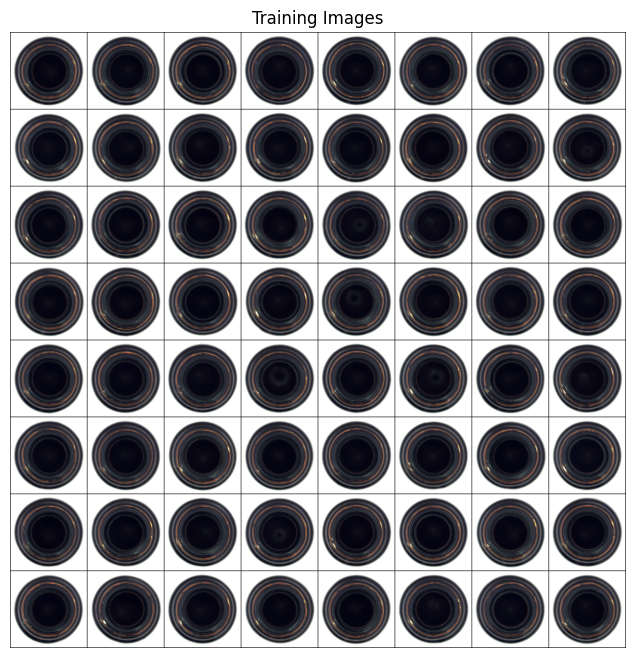

In [50]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)), cmap='gray')

In [51]:
import torch
import torch.nn as nn
from torchvision import models

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()

        # 使用 ResNet-18 作為 Encoder
        vit_b_16 = models.vit_b_16(weights='IMAGENET1K_V1')
        self.encoder = nn.Sequential(
            *list(vit_b_16.children())[:-2],  # 移除最後的全連接層和 AvgPool
            nn.AdaptiveAvgPool2d((1, 1)),     # 將特徵圖縮小為 (1, 1)
            nn.Flatten(),                     # 展平
            nn.Linear(768, latent_dim * 2)    # 輸出 mu 和 logvar
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * (image_size // 8) * (image_size // 8)),
            nn.ReLU(),
            nn.Unflatten(1, (128, image_size // 8, image_size // 8)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output range [-1, 1]
        )

        # self.apply(self.initialize_weights_kaiming)

    def initialize_weights_kaiming(self, m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=-1)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar


In [52]:
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

In [53]:
train_losses = []
val_losses = []

def train_vae(model, train_loader, val_loader, optimizer, scheduler, epochs=10):
    global train_losses, val_losses
    train_losses.clear()
    val_losses.clear()
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_x, mu, logvar = model(data)
            loss = loss_function(recon_x, data, mu, logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        scheduler.step()

        # Validation Phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                recon_x, mu, logvar = model(data)
                val_loss += loss_function(recon_x, data, mu, logvar).item()
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}.. Train Loss: {train_loss:.4f}.. Val Loss: {val_loss:.4f}")

In [54]:
latent_dim = 128
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

train_vae(model, train_loader, val_loader, optimizer, scheduler=scheduler, epochs=500)

Epoch 1/500.. Train Loss: 102373.4012.. Val Loss: 101024.2143
Epoch 2/500.. Train Loss: 101148.2395.. Val Loss: 97024.4940
Epoch 3/500.. Train Loss: 97179.4311.. Val Loss: 87876.8095
Epoch 4/500.. Train Loss: 88449.1557.. Val Loss: 75471.6964
Epoch 5/500.. Train Loss: 75622.1677.. Val Loss: 70809.9345
Epoch 6/500.. Train Loss: 70369.3293.. Val Loss: 67694.4345
Epoch 7/500.. Train Loss: 67132.9641.. Val Loss: 61651.3750
Epoch 8/500.. Train Loss: 61526.0599.. Val Loss: 57499.1488
Epoch 9/500.. Train Loss: 57501.4671.. Val Loss: 53561.4048
Epoch 10/500.. Train Loss: 53790.1317.. Val Loss: 48053.6012
Epoch 11/500.. Train Loss: 47771.6377.. Val Loss: 40393.8839
Epoch 12/500.. Train Loss: 40720.6228.. Val Loss: 33278.9881
Epoch 13/500.. Train Loss: 33275.9311.. Val Loss: 26986.1012
Epoch 14/500.. Train Loss: 27121.1946.. Val Loss: 22093.0432
Epoch 15/500.. Train Loss: 22086.5883.. Val Loss: 17309.4643
Epoch 16/500.. Train Loss: 17236.4027.. Val Loss: 13453.3065
Epoch 17/500.. Train Loss: 133

KeyboardInterrupt: 

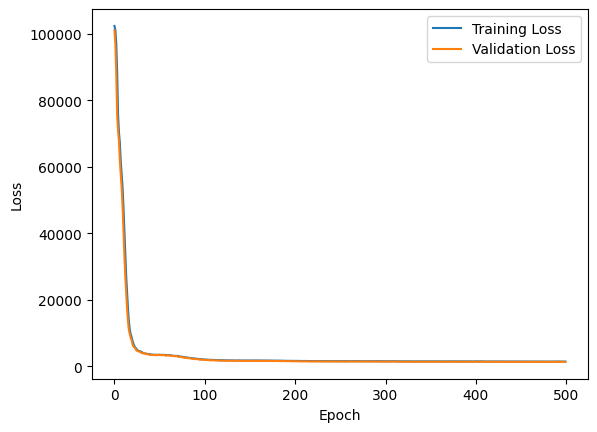

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Calculate the reconstruction loss
The reconstruction loss between good products and defective products should have difference.

You can use the following codes to evaluate the reconstruction loss, and find something useful information.

good avg:  1624.8450958251954
defective avg:  3119.7854042658732


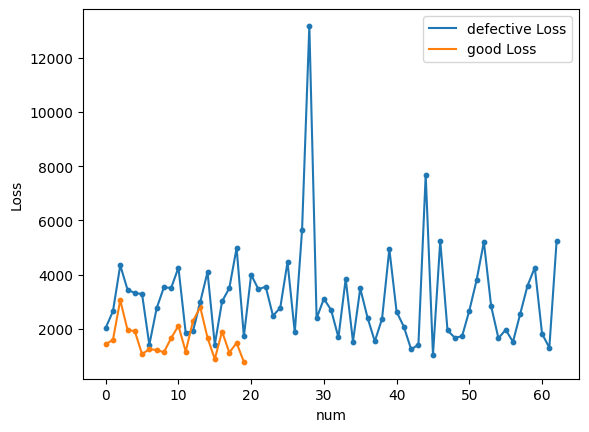

In [ ]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt

def test(image_path, vae, device):
    img = Image.open(image_path)
    img = transform(img).to(device)
    img = img.unsqueeze(0)

    vae.eval()
    with torch.no_grad():
        recon, mu, log_var = vae(img)
        test_loss = loss_function(recon, img, mu, log_var)
        return test_loss.item()

testimg_dir = './data/test/bottle/good'
testimg_dir2 = './data/test/bottle/error'

good = []
error = []
for img_file in os.listdir(testimg_dir):
    img_path = os.path.join(testimg_dir, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        good.append(test(img_path, model, device))

for img_file in os.listdir(testimg_dir2):
    img_path = os.path.join(testimg_dir2, img_file)
    if os.path.isfile(img_path):
        test(img_path, model, device)
        error.append(test(img_path, model, device))

plt.plot(error, label='defective Loss')
plt.scatter(range(len(error)), error, s=10)
plt.plot(good, label='good Loss')
plt.scatter(range(len(good)), good, s=10)
plt.xlabel('num')
plt.ylabel('Loss')
plt.legend()

print("good avg: ", sum(good)/len(good))    
print("defective avg: ", sum(error)/len(error))

## Calculate Accuracy
You need to calculate the accuracy of products' predictions. 

A easy way is to use the reconstruction loss to distinguish between goods and defective ones.

It is not restricted to use this way, you also can use another methods and write they into report.

In [ ]:
import random
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def worker_init_fn(worker_id):
    worker_seed = torch.initial_seed() % (2**32 - 1)
    np.random.seed(worker_seed)

set_seed(42)

In [ ]:
def calculate_accuracy(threshold=100.0):
    set_seed(42)
    correct = 0
    total = 0
    # Good products
    for img_file in os.listdir(testimg_dir):
        img_path = os.path.join(testimg_dir, img_file)
        if os.path.isfile(img_path):
            loss = test(img_path, model, device)
            if loss < threshold:
                correct += 1
            total += 1

    # Defective products
    for img_file in os.listdir(testimg_dir2):
        img_path = os.path.join(testimg_dir2, img_file)
        if os.path.isfile(img_path):
            loss = test(img_path, model, device)
            if loss >= threshold:
                correct += 1
            total += 1

    accuracy = correct / total * 100
    return accuracy


def find_best_threshold(low=0, high=2000, tolerance=1):
    """
    使用三分搜尋找到最佳的 threshold。
    """
    set_seed(42)
    best_threshold = 0
    best_accuracy = 0

    while high - low > tolerance:
        # 計算兩個中點
        mid1 = low + (high - low) // 3
        mid2 = high - (high - low) // 3

        # 計算兩個中點的準確率
        accuracy1 = calculate_accuracy(mid1)
        accuracy2 = calculate_accuracy(mid2)

        print(accuracy1, mid1, accuracy2, mid2)

        # 比較兩個中點的準確率
        if accuracy1 > accuracy2:
            if accuracy1 > best_accuracy:
                best_accuracy = accuracy1
                best_threshold = mid1
            high = mid2 - 1
        else:
            if accuracy2 > best_accuracy:
                best_accuracy = accuracy2
                best_threshold = mid2
            low = mid1 + 1

    return best_threshold, best_accuracy

In [ ]:
find_best_threshold(low=0, high=4500, tolerance=1)
print(calculate_accuracy(1125))

75.90361445783132 1500 56.62650602409639 3000
77.10843373493977 999 71.08433734939759 2000
75.90361445783132 666 80.72289156626506 1333
79.51807228915662 1111 72.28915662650603 1555
77.10843373493977 962 80.72289156626506 1259
80.72289156626506 1160 79.51807228915662 1357
79.51807228915662 1094 80.72289156626506 1225
81.92771084337349 1182 80.72289156626506 1269
79.51807228915662 1152 80.72289156626506 1211
81.92771084337349 1191 80.72289156626506 1230
81.92771084337349 1178 81.92771084337349 1204
81.92771084337349 1195 80.72289156626506 1213
81.92771084337349 1190 81.92771084337349 1201
81.92771084337349 1198 81.92771084337349 1205
81.92771084337349 1203 80.72289156626506 1208
81.92771084337349 1201 81.92771084337349 1205
81.92771084337349 1203 81.92771084337349 1206
81.92771084337349 1205 81.92771084337349 1206
79.51807228915662
